In [1]:
# preprocessing
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import re
# machine learning
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import string
import tensorflow_hub as hub
# visualization
import seaborn as sns

In [2]:
#'''
kaggle_1 = pd.read_csv('datasets\Youtube01-Psy.csv')
kaggle_2 = pd.read_csv('datasets\Youtube02-KatyPerry.csv')
kaggle_3 = pd.read_csv('datasets\Youtube03-LMFAO.csv')
kaggle_4 = pd.read_csv('datasets\Youtube04-Eminem.csv')
kaggle_5 = pd.read_csv('datasets\Youtube05-Shakira.csv')
# combine kaggle datasets
df = pd.concat([kaggle_1, kaggle_2, kaggle_3, kaggle_4, kaggle_5], ignore_index=True)
# remove blank and duplicate rows
df = df.replace('', float('NaN')).dropna().drop_duplicates()
# select relevant features
df = df[['CONTENT', 'CLASS']]
# rename features
df.rename(columns={'CONTENT': 'comment', 'CLASS': 'target'}, inplace=True)
# add custom dataset
custom_df_1 = pd.read_csv('datasets\youtube_comments.csv', delimiter=';')
custom_df_2 = pd.read_csv('datasets\custom_comments.csv')
custom_df_1 = custom_df_1[['Comment', 'Spam']]
custom_df_1.rename(columns={'Comment': 'comment', 'Spam': 'target'}, inplace=True)
df = pd.concat([df, custom_df_1, custom_df_2], ignore_index=True)
df.shape
#'''

(17297, 2)

In [3]:
df = df.replace('', float('NaN')).dropna().drop_duplicates()
#df = df.dropna()
df.head()

,comment,target
0,"Huh, anyway check out this you[tube] channel: ...",1.0
1,Hey guys check out my new channel and our firs...,1.0
2,just for test I have to say murdev.com,1.0
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1.0
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1.0


Not Spam: 1944
Spam: 989


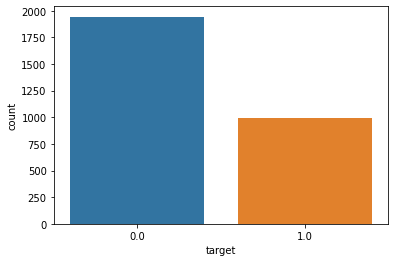

In [4]:
print('Not Spam: {}'.format(len(df[df['target'] == 0])))
print('Spam: {}'.format(len(df[df['target'] == 1])))
sns.countplot(x='target', data=df);

In [5]:
wordnet_lemmatizer = WordNetLemmatizer()

progress = 0
length = len(df)

def pre_process(text):
    global progress
    progress += 1
    '''
    - transform to lowercase
    - remove links and mentions
    - remove all characters except whitespaces and latin characters
    - word tokenization
    - lemmatization
    '''
    removed_mentions = re.sub(r'\s?@(\s)*(\S*)\s?', ' ', text)
    removed_links = re.sub(r'((http|watch\?v=|[wW]{3})\S+)', ' ', removed_mentions)
    normalized = re.sub(r'[^A-Za-z]+', ' ', removed_links)
    tokens = word_tokenize(normalized)
    tokens = [word for word in tokens if not word in stopwords.words('english')]

    print(f'{progress / length * 100:.2f}%\t{progress}/{length}', end='\r')
    return ' '.join(tokens).lower()

df['cleaned'] = df['comment'].apply(pre_process)
df

,comment,target,cleaned
0,"Huh, anyway check out this you[tube] channel: ...",1.0,huh anyway check tube channel kobyoshi
1,Hey guys check out my new channel and our firs...,1.0,hey guys check new channel first vid this is u...
2,just for test I have to say murdev.com,1.0,test i say murdev com
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1.0,shaking sexy ass channel enjoy
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1.0,check
...,...,...,...
17292,finally it's here,1.0,finally
17293,finally its here,1.0,finally
17294,congratulations you won a giveaway,1.0,congratulations giveaway
17295,Congratulations you've been shortlisted for a ...,1.0,congratulations shortlisted prize send text ac...


In [6]:
X = df['cleaned'].values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
print(len(X_train))
print(len(X_test))

2346
587


In [7]:
hub_layer = hub.KerasLayer('nnlm_en_dim50_2', input_shape=[], dtype=string, trainable=True)

# define model
model = Sequential()
model.add(hub_layer)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
hist = model.fit(
	X_train,
	y_train,
	epochs=100,
	batch_size=300,
	validation_data=(X_test, y_test),
	callbacks=[early_stop]
)
acc = max(hist.history['val_accuracy'])
print(f'acc: {round(acc * 100, 2)}%')
# save model
model.save('spam_detector')

Epoch 1/100
8/8 [==============================] - 7s 283ms/step - loss: 0.6655 - accuracy: 0.6296 - val_loss: 0.6535 - val_accuracy: 0.6746
Epoch 2/100
8/8 [==============================] - 1s 68ms/step - loss: 0.6214 - accuracy: 0.7447 - val_loss: 0.6231 - val_accuracy: 0.7342
Epoch 3/100
8/8 [==============================] - 1s 66ms/step - loss: 0.5837 - accuracy: 0.7907 - val_loss: 0.5954 - val_accuracy: 0.7547
Epoch 4/100
8/8 [==============================] - 1s 66ms/step - loss: 0.5466 - accuracy: 0.8116 - val_loss: 0.5687 - val_accuracy: 0.7649
Epoch 5/100
8/8 [==============================] - 1s 66ms/step - loss: 0.5086 - accuracy: 0.8333 - val_loss: 0.5412 - val_accuracy: 0.7785
Epoch 6/100
8/8 [==============================] - 1s 65ms/step - loss: 0.4693 - accuracy: 0.8508 - val_loss: 0.5131 - val_accuracy: 0.7956
Epoch 7/100
8/8 [==============================] - 1s 66ms/step - loss: 0.4288 - accuracy: 0.8657 - val_loss: 0.4862 - val_accuracy: 0.8058
Epoch 8/100
8/8 [==

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:GPU:0 to /job:localhost/replica:0/task:0/device:CPU:0 in order to run Identity: Dst tensor is not initialized. [Op:Identity]

In [8]:
test_comments = [
    # spam
    "That's nice, thanks for replying, you can send a message to my administrator on watsap to earn in crypto especially Bitcoin ...+\u202a..1..6.1..3..6.0..4..5..7..4..7 He's excellent at what he does, tell him referred you to him. His passionate strategies are top notch the ✌️🇺🇸",
    "I’m so happy I met RM_KESH01 on Insta he help me recover my lost Erc20 sent to a wrong network I’m so happy because his trusted and reliable"
    "This is wonderful and unbelievable just got my Bitcoin account back through Doavercracks on ig thanks a lot really appreciate it.",
    "I recommend y’all to Doavercracks on IG.",
    "BTC price to volatiles swing, making it historically popular for traders to speculate on. According to bitcoin having cycles, there should be at least other four months in this bull run, so, if the Pi indicator (and bitcoin) might repeat a similar bull run to 2013,that would mean a local top relatively close in time and then another top to end the bull run towards mid year, investor's and trader's find it difficult to decide how best to utilize the current market, holding is profitable but trading is far more profitable, I was able to grasp knowledge of trading crypto assets earlier enough, I didn't think it was possible to make constant win from trading till I come across Mrs milly program for investor's and newbies who lack understanding on how trading BTC works, to help them stack up more bitcoin, since late last year till date I have made over 19BTC from 2.6BTC with Mrs milly's help, you can easily get to her with this WhatsApp number +1-2-1-0-8-0-6-4-8-8-9",
    "Never thought it was possible to recover my lost btc until I meet victoolz on insta who helped me...",
    "Can’t recommend him enough for his tireless effort and tremendous job done Doavercracks on IG his truly the best 💯💯",
    "𝟰𝗕𝗧𝗖 𝘄𝗮𝘀 𝘀𝗲𝗻𝘁 𝘁𝗼 𝗺𝘆 𝗯𝗹𝗼𝗰𝗸𝗰𝗵𝗮𝗶𝗻 𝗮𝗰𝗰𝗼𝘂𝗻𝘁 𝗜'𝗺 𝘁𝗵𝗮𝗻𝗸𝗶𝗻𝗴 𝗚𝗼𝗱  𝗳𝗼𝗿 𝘀𝗲𝗻𝗱𝗶𝗻𝗴 𝗜𝗢𝗦𝗧𝗢𝗢𝗟𝗦 𝗼𝗻 !𝗚 𝗳𝗼𝗿 𝘀𝗮𝘃𝗶𝗻𝗴 𝗺𝘆 𝗹𝗶𝗳𝗲",
    "Another 0.05682 bitcoin was recover by this Dude *DANTECHIES* on instagram, I appreciate the work he did for me..",
    "😭😢😭😭 *core_cyber* on Instagram just made me proud, thank you so much sir..",
    "Xavier is wonderful, I traded with him and made huge profits",
    "Contact Mr. Decuyper on msgnr for advice",
    # Not spam
    "Amazing video!",
    "Maybe to make proof of stake system more democraric we can think about share a certain amount of money the validator get to all the other validators?",
    "I don’t get it 😅😂",
    "Watching this video as El Salvador 🇸🇻 just made bitcoin a legal tender..lol",
    "finally it's here",
    "dont read my username",
    "don't read my username",
    "congratulations you won a giveaway"
]

for test in test_comments:
    score = round(model.predict([pre_process(test)], verbose=0)[0][0] * 100, 2)
    print(f"{'SPAM' if int(score) > 50 else 'HAM'} - {score}% - {test}")

SPAM - 99.82% - That's nice, thanks for replying, you can send a message to my administrator on watsap to earn in crypto especially Bitcoin ...+‪..1..6.1..3..6.0..4..5..7..4..7 He's excellent at what he does, tell him referred you to him. His passionate strategies are top notch the ✌️🇺🇸
SPAM - 98.01% - I’m so happy I met RM_KESH01 on Insta he help me recover my lost Erc20 sent to a wrong network I’m so happy because his trusted and reliableThis is wonderful and unbelievable just got my Bitcoin account back through Doavercracks on ig thanks a lot really appreciate it.
SPAM - 98.5% - I recommend y’all to Doavercracks on IG.
SPAM - 99.33% - BTC price to volatiles swing, making it historically popular for traders to speculate on. According to bitcoin having cycles, there should be at least other four months in this bull run, so, if the Pi indicator (and bitcoin) might repeat a similar bull run to 2013,that would mean a local top relatively close in time and then another top to end the bull

In [ ]:
#

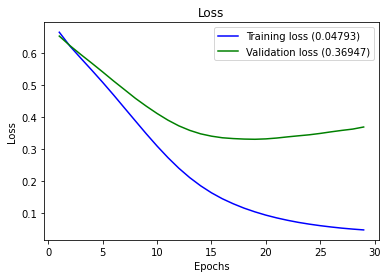

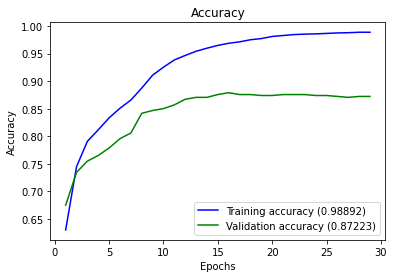

In [9]:
# plot loss and accuracy
import matplotlib.pyplot as plt

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    # As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    
    # Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(hist)